In [1]:
from uproot_io import Events, View
import numpy as np
from numpy import *
import matplotlib
import matplotlib.pyplot as plt
titlesize = 20
labelsize = 14

In [2]:
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")

In [3]:
def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def inlierplot(event_number, plot):
    idx = np.where(events.event_number == event_number)[0]
    resis = []
    gradients = []
    intercepts = []
    particleType = []
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]
    if plot == True:
        plt.scatter(vx, vz, c='red', s=50)

    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if plot == True:
            plt.scatter(x0, z0, s=0.5)
        
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)
        
    if vx < xmin:
        xmin = vx    
    if vx > xmax:
        xmax = vx
    if vz < zmin:
        zmin = vz    
    if vz > zmax:
        zmax = vz

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    if plot == True:
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
        plt.show()
        
        plt.scatter(vx, vz, c='red', s=50)
        plt.xlim(xmin-xlen, xmax+xlen)
        plt.ylim(zmin-zlen, zmax+zlen)
    
    for i in idx:
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        pdg = events.mc_pdg[i]
        
        particleType.append(pdg)
        if pdg == 0:
            gradients.append(0)
            intercepts.append(0)
            resis.append(0)
        
        else:
            if plot == True:
                plt.scatter(x, z, s=0.5)

            best_inliers = []
            best_model = None
            sample_size = 10
            max_iterations = 250
            #inlier_threshold = 2.0

            for _ in range(max_iterations):
                sample_size = min(sample_size, len(x))
                sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
                x_sample = x[sample_indices]
                z_sample = z[sample_indices]

                m, c = fit_line(x_sample, z_sample)
                residuals = calculate_residuals(x, z, m, c)
                inliers = np.where(residuals < (0.15*xlen))[0]

                if len(inliers) > len(best_inliers):
                    best_inliers = inliers
                    best_model = (m, c)

            if len(best_inliers) > 0:
                m, c = best_model
                gradients.append(m)
                intercepts.append(c)

                if plot == True:
                    x_inliers = x[best_inliers]
                    z_inliers = z[best_inliers]
                    plt.scatter(x_inliers, z_inliers, color='blue', marker='o')

                    plt.plot(x_inliers, m * x_inliers + c)
                    plt.xlabel('x')
                    plt.ylabel('w')

                perp_dist = [calculate_residuals(x[i], z[i], m, c) for i in range(len(x))]
                start = int(0.25 * len(x))
                end = int(start*3)
                mean = np.mean(perp_dist[start:end])
                #mean = np.mean(perp_dist)
                NaN = isnan(mean)
                if NaN == True:
                    resis.append(0)
                if NaN == False:
                    resis.append(mean)
            else:
                gradients.append(1)
                intercepts.append(1)
                resis.append(1)
                #print("No inliers found for a particle")
                continue
    
    if plot == True:
        plt.show()
    
    return np.array(np.stack((gradients, intercepts, resis, particleType)))

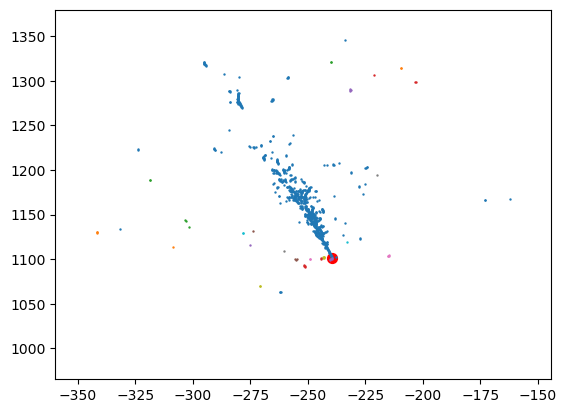

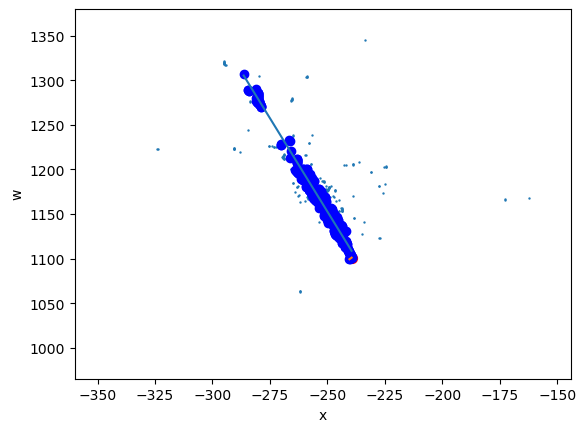

array([[-4.18291712e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.87413704e+00],
       [ 1.07088867e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.54989087e+03],
    

In [4]:
inlierplot(646, True)

In [5]:
import math
#all 0 = unimportant particle
#all 1 = failed fit

def coords(event_number):
    array = inlierplot(event_number, False)
    m = array[0, :]
    c = array[1, :]
    r = array[2, :]
    part = array[3, :]
    
    residuals = []
    
    #print(part)
    idx = np.where(events.event_number == event_number)[0]
    newidx = idx - idx[0]
    for i in newidx:
        if part[i] == 0 or r[i] == 0 or r[i] == 1:
        #if m[i] == 0 and c[i] == 0 and r[i] == 0:
            residuals.append(0)
        #if m[i] == 1 and c[i] == 1 and r[i] == 1:
        #    residuals.append(0)
        else:
            x = events.reco_hits_x_w[i+idx[0]]
            z = events.reco_hits_w[i+idx[0]]

            znew = z - c[i]

            angle = -math.atan(m[i])

            l = x * np.cos(angle) - znew * np.sin(angle)
            t = x * np.sin(angle) + znew * np.cos(angle)
            #plt.scatter(l,t)
            #plt.show()
            mean = np.mean(abs(t))
            NaN = isnan(mean)
            if NaN == True:
                residuals.append(0)
            if NaN == False:
                residuals.append(mean)
    
    residuals = np.array(residuals)
    return part, r

part, res = coords(336)
print(np.shape(part), np.shape(res))

(41,) (41,)


In [18]:
#electron = +-11, photon = 22

def histplot(num):
    tracks = []
    showers = []
    tnumber = []
    snumber = []
    tindex = []
    sindex = []
    
    random_numbers = np.random.randint(0, max(events.event_number), num)
    
    for n in random_numbers:
        part, res = coords(n)
        for i in range(len(res)):
            if res[i] != 0 and res[i] != 1 and res[i] <= 30:
                if part[i] == 22. or part[i] == -11. or part[i] == 11.:
                    showers.append(res[i])
                    snumber.append(n)
                    sindex.append(i)
                else:
                    tracks.append(res[i])
                    tnumber.append(n)
                    tindex.append(i)
    
    bin_width = 0.5
    bin_edges = np.arange(0, 10.5, bin_width)
    hist1, _ = np.histogram(tracks, bins=bin_edges)
    hist2, _ = np.histogram(showers, bins=bin_edges)
   
    hist1_normalized = hist1 / len(tracks)
    hist2_normalized = hist2 / len(showers)

    plt.bar(bin_edges[:-1], hist1_normalized, width=bin_width, align='edge', alpha=0.75, label='Tracks')
    plt.bar(bin_edges[:-1], hist2_normalized, width=bin_width, align='edge', alpha=0.75, label='Showers')
    
    plt.xlabel('Mean Residuals from Straight Line Fit')
    plt.legend()
    plt.show()
    
    showers = np.array(showers)
    snumber = np.array(snumber)
    sindex = np.array(sindex)
    tracks = np.array(tracks)
    tnumber = np.array(tnumber)
    tindex = np.array(tindex)
    
    ssorted = np.argsort(showers)
    showers = showers[ssorted]
    snumber = snumber[ssorted]
    sindex = sindex[ssorted]
    
    tsorted = np.argsort(tracks)
    tracks = tracks[tsorted]
    tnumber = tnumber[tsorted]
    tindex = tindex[tsorted]
    
    #Now need to use hist_normalized to get proportions of particles in each bin
    
    return showers, snumber, sindex, tracks, tnumber, tindex

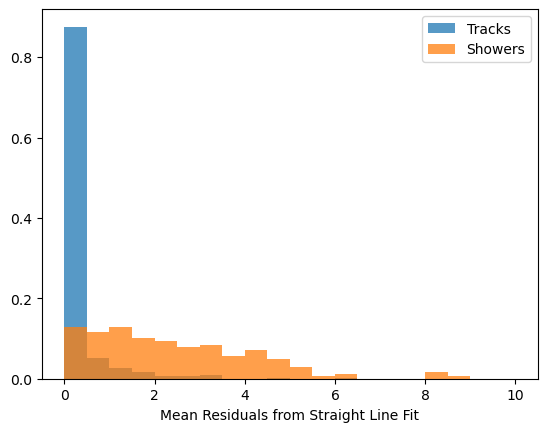

[ 0.02652526  0.04639124  0.07038533  0.09902216  0.10790434  0.1244087
  0.12549554  0.16539341  0.23443327  0.26627399  0.26929672  0.27566303
  0.31855025  0.34010763  0.35723282  0.40353674  0.40780949  0.41756131
  0.435148    0.43693405  0.45670827  0.46828138  0.47599511  0.50055278
  0.5148932   0.59010551  0.63946691  0.65103912  0.68546062  0.69307697
  0.69984676  0.70389315  0.7104806   0.72249642  0.72993236  0.75766318
  0.78178104  0.78214781  0.78239182  0.78593073  0.79430525  0.79682144
  0.89177362  0.92874531  1.03906751  1.041543    1.09293495  1.12412902
  1.13235107  1.14666804  1.15603559  1.16930225  1.18395211  1.2068979
  1.24110217  1.29419648  1.32506998  1.33398339  1.33424202  1.37128538
  1.41644004  1.41830757  1.47999173  1.48050611  1.48081512  1.48083774
  1.49536643  1.50916925  1.53383515  1.53730516  1.58214726  1.59360788
  1.6141577   1.62273707  1.62514751  1.63532752  1.71842653  1.72222557
  1.82369056  1.86390297  1.89534137  1.91424203  1.9

In [19]:
sh, sn, si, tr, tn, ti = histplot(100)
print(sh)
print(sn)
print(si)

In [51]:
def eventplot(number, TorS):
    bin_width = 0.5
    if TorS == 1:
        rounded = [bin_width * math.floor(x / bin_width) for x in sh]
        indices = [i for i, x in enumerate(rounded) if x == number]
        random_index = np.random.choice(indices)
        nvalue = sn[random_index]
        ivalue = si[random_index]
    
    if TorS == 0:
        rounded = [bin_width * math.floor(x / bin_width) for x in tr]
        indices = [i for i, x in enumerate(rounded) if x == number]
        random_index = np.random.choice(indices)
        nvalue = tn[random_index]
        ivalue = ti[random_index]
    
    idx = np.where(events.event_number == nvalue)[0]
    
    vx = events.true_neutrino_vtx_x[idx[0]]
    vz = events.true_neutrino_vtx_w[idx[0]]
    plt.scatter(vx, vz, c='red', s=50)
    
    for i in idx:
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        plt.scatter(x, z, s=0.5)
    
    x0 = events.reco_hits_x_w[idx[ivalue]]
    z0 = events.reco_hits_w[idx[ivalue]]
    plt.scatter(x0, z0, c='blue', s=5)
    
    plt.show()

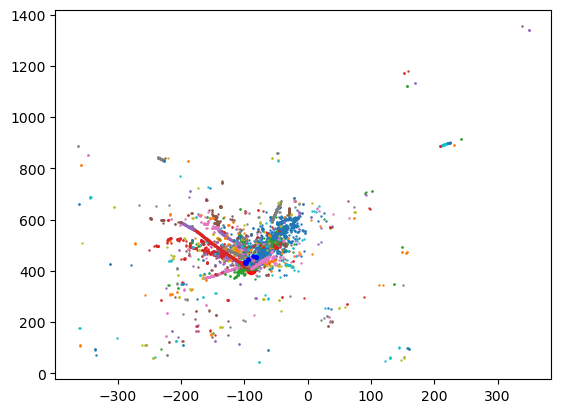

In [52]:
eventplot(1.0, 1)